# Pytorch tests

Here I will check my installation of pytorch and play around a bit

In [1]:
import torch

Checking installation:

In [27]:
x = torch.rand(5, 3)
print(x)

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

tensor([[0.1829, 0.9668, 0.6671],
        [0.0471, 0.0678, 0.7549],
        [0.1198, 0.3546, 0.1133],
        [0.5922, 0.3245, 0.7880],
        [0.2260, 0.1860, 0.1193]])
Using cpu device


### Now, onto more fullfilling tests, getting used to pytorch API.

Using https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html as a guide

In [11]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [12]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5])


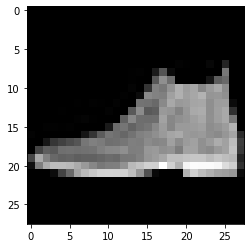

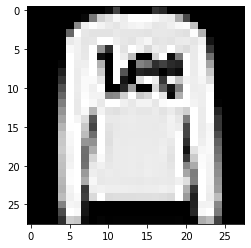

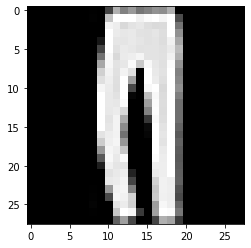

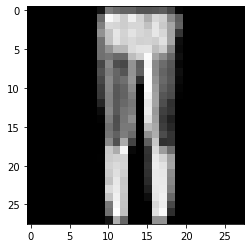

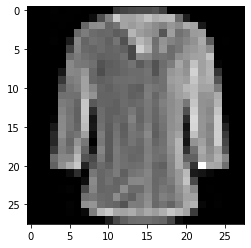

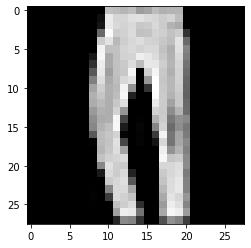

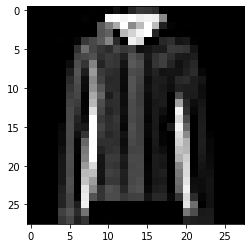

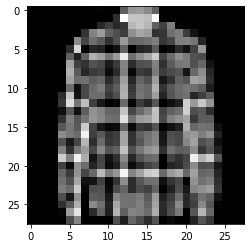

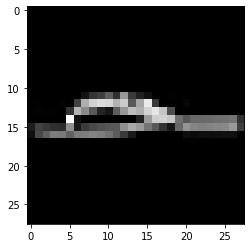

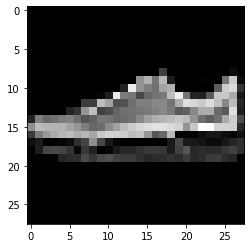

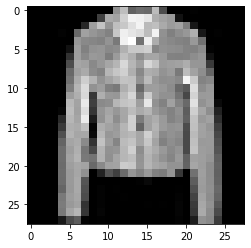

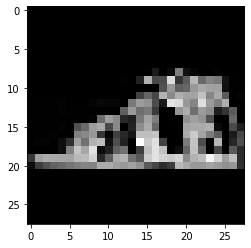

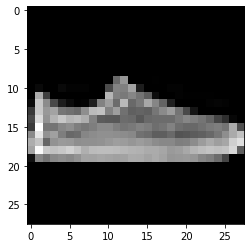

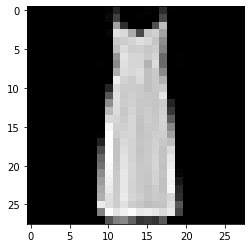

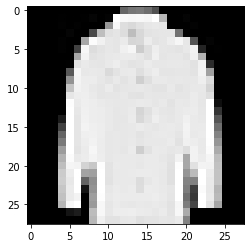

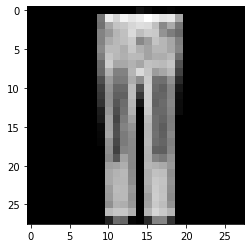

In [23]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(y)
    for j in range(batch_size//4):
        plt.imshow(X[j,0,:,:], cmap="gray")
        plt.show()
    break
    

To define a neural network in PyTorch, we create a class that inherits from `nn.Module`. We define the layers of the network in the `__init__` function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [25]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [28]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), # input is 28x28, 512 nodes
            nn.ReLU(), # relu activation
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10) # 10 outputs
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To train a model, we need a loss function and an optimizer.

In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [30]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model’s performance against the test dataset to ensure it is learning.

In [31]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.



In [32]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.298691  [    0/60000]
loss: 2.283312  [ 6400/60000]
loss: 2.261529  [12800/60000]
loss: 2.257039  [19200/60000]
loss: 2.247351  [25600/60000]
loss: 2.219528  [32000/60000]
loss: 2.227249  [38400/60000]
loss: 2.191458  [44800/60000]
loss: 2.192073  [51200/60000]
loss: 2.166509  [57600/60000]
Test Error: 
 Accuracy: 50.6%, Avg loss: 2.160288 

Epoch 2
-------------------------------
loss: 2.168740  [    0/60000]
loss: 2.158468  [ 6400/60000]
loss: 2.101705  [12800/60000]
loss: 2.116046  [19200/60000]
loss: 2.071100  [25600/60000]
loss: 2.013389  [32000/60000]
loss: 2.035834  [38400/60000]
loss: 1.959683  [44800/60000]
loss: 1.960003  [51200/60000]
loss: 1.891371  [57600/60000]
Test Error: 
 Accuracy: 61.1%, Avg loss: 1.897445 

Epoch 3
-------------------------------
loss: 1.924967  [    0/60000]
loss: 1.900952  [ 6400/60000]
loss: 1.785132  [12800/60000]
loss: 1.818205  [19200/60000]
loss: 1.715851  [25600/60000]
loss: 1.661666  [32000/600

## Saving Models

A common way to save a model is to serialize the internal state dictionary (containing the model parameters).

In [33]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


# Loading Models

The process for loading a model includes re-creating the model structure and loading the state dictionary into it.

In [34]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

### Now, to make predictions!

Predicted: "Trouser", Actual: "Trouser"


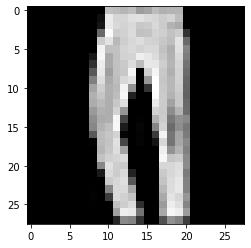

Predicted: "Coat", Actual: "Coat"


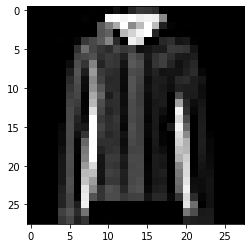

Predicted: "Coat", Actual: "Shirt"


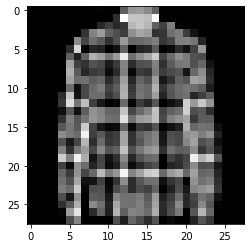

Predicted: "Sneaker", Actual: "Sandal"


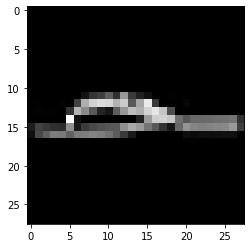

Predicted: "Sneaker", Actual: "Sneaker"


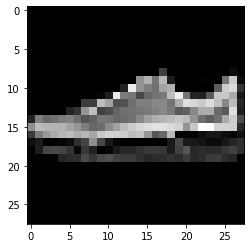

Predicted: "Coat", Actual: "Coat"


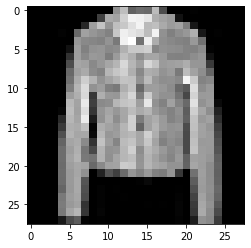

In [49]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
for j in range(5,11):
    x, y = test_data[j][0], test_data[j][1]
    with torch.no_grad(): # don't need to track the gradients since no backprop needed
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        print(f'Predicted: "{predicted}", Actual: "{actual}"')
        plt.imshow(test_data[j][0][0], cmap="gray")
        plt.show()